# Solver and SLM Accuracy and Runtime Notebook

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
# from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicSpline
from matplotlib.ticker import ScalarFormatter
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
# import json


import sys
sys.path.append("./src")
from TOV_class import TOVsolver
from SLM import DMD
import scripts as plot_scripts  # plotting functions
plot_scripts.setup_rc_params()

In [3]:
# real quick let's get the SLM main code "wrapped" into a function I can call from here

SLM_modes = 8

def SLM(X, svdSize=SLM_modes):
    radius, pres, mass, tidal_def = X
    
    # get data defined and "formatted"
    linT = np.arange(len(pres))
    X = [np.log(radius), np.log(pres), np.log(mass), np.log(tidal_def)]
    X = np.asarray(X, dtype=np.float64)
    
    startDMDTime = time.time()
    phi, omega, lam, b, Xdmd, S = DMD(X, svdSize, (linT[-1] - linT[0]) / len(linT))
    endDMDTime = time.time()
    runtime = endDMDTime - startDMDTime
    
    rad_DMD = np.exp(Xdmd[0].real)
    pres_DMD = np.exp(Xdmd[1].real)
    mass_DMD = np.exp(Xdmd[2].real)
    tidal_DMD = np.exp(Xdmd[3].real)
    
    
    return rad_DMD, pres_DMD, mass_DMD, tidal_DMD, runtime

In [4]:
eos_path = "./EOS_Data/"

# check the accuracy and runtimes with the tabular EOSs (5 of them)
files_to_check = ["BL_eos.table", 
                  "FSUGarnetNStarEOSA.txt", 
                  "sorted_Sly4.dat", 
                  "DS_CMF_eos.table", 
                  "apr_eos.table"]
eos_names = ["BL", "FSU Garnet", "SLy4", "DSCMF", "APR"]

In [5]:
sol_pts = 2500  # number of points used per iteration for non solve_ivp solvers
number_of_solves = 1  # make this more for checking the runtimes !

# these empty lists will get filled with their corresponding runtimes per solve (size = `number_of_solves * 5`)
HF_runtimes = {"exact": [],
               "RK4": [],
               "RK2": [],
               "euler": []}
SLM_runtimes = {"exact": [],
                "RK4": [],
                "RK2": [],
                "euler": []}

## Calculate Exact (Adaptive) Solver

This uses `solve_ivp`

In [6]:
# store the solutions per EOS
exact_HF_results = {}
exact_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        # some solve_ivp methods: "RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"
        # "Radau" is particularly good for stick ODEs (like these). But RK45 should also be good too.
        tov_exact = TOVsolver(f"{eos_path}{file}", tidal=True, solver="solve_ivp", solve_ivp_kwargs={"method": "RK45", 
                                                                                                        "atol": 1e-12, 
                                                                                                        "rtol": 1e-12})
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_exact.tov_routine(verbose=False, write_to_file=False, pres_init=2.0)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["exact"].append(HF_runtime)
        
        # store data
        rad = tov_exact.total_radius
        pres = tov_exact.total_pres_central
        mass = tov_exact.total_mass
        tidal = tov_exact.k2
        
        X = np.array([rad, pres, mass, tidal], dtype=np.float64)
        
        
        # Run the SLM code (that I've copy-and-pasted into this notebook).
        rad_SLM, pres_SLM, mass_SLM, tidal_SLM, SLM_runtime = SLM(X, svdSize=SLM_modes)
        X_SLM = np.array([rad_SLM, pres_SLM, mass_SLM, tidal_SLM], dtype=np.float64)
        SLM_runtimes["exact"].append(SLM_runtime)
        
        exact_HF_results[eos_name] = X
        exact_SLM_results[eos_name] = X_SLM
        
        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
#




Checking BL: Woo it worked!
Max mass:  2.082757 Radius:  10.198012 Central pressure:  867.67565
(14, 50) 4
HF solved in 15.94 seconds.
SLM solved in 0.0006008 seconds.


Checking FSU Garnet: Woo it worked!
Max mass:  2.066602 Radius:  11.640178 Central pressure:  342.097307
(14, 50) 4
HF solved in 23.9 seconds.
SLM solved in 0.0005591 seconds.


Checking SLy4: Woo it worked!
Max mass:  2.067066 Radius:  10.037464 Central pressure:  867.67565
(14, 50) 4
HF solved in 11.04 seconds.
SLM solved in 0.0005 seconds.


Checking DSCMF: Woo it worked!
Max mass:  2.022887 Radius:  11.902672 Central pressure:  292.942036
(14, 50) 4
HF solved in 15.54 seconds.
SLM solved in 0.0005882 seconds.


Checking APR: Woo it worked!
Max mass:  2.192606 Radius:  9.987935 Central pressure:  1013.27043
(14, 50) 4
HF solved in 15.47 seconds.
SLM solved in 0.0005682 seconds.


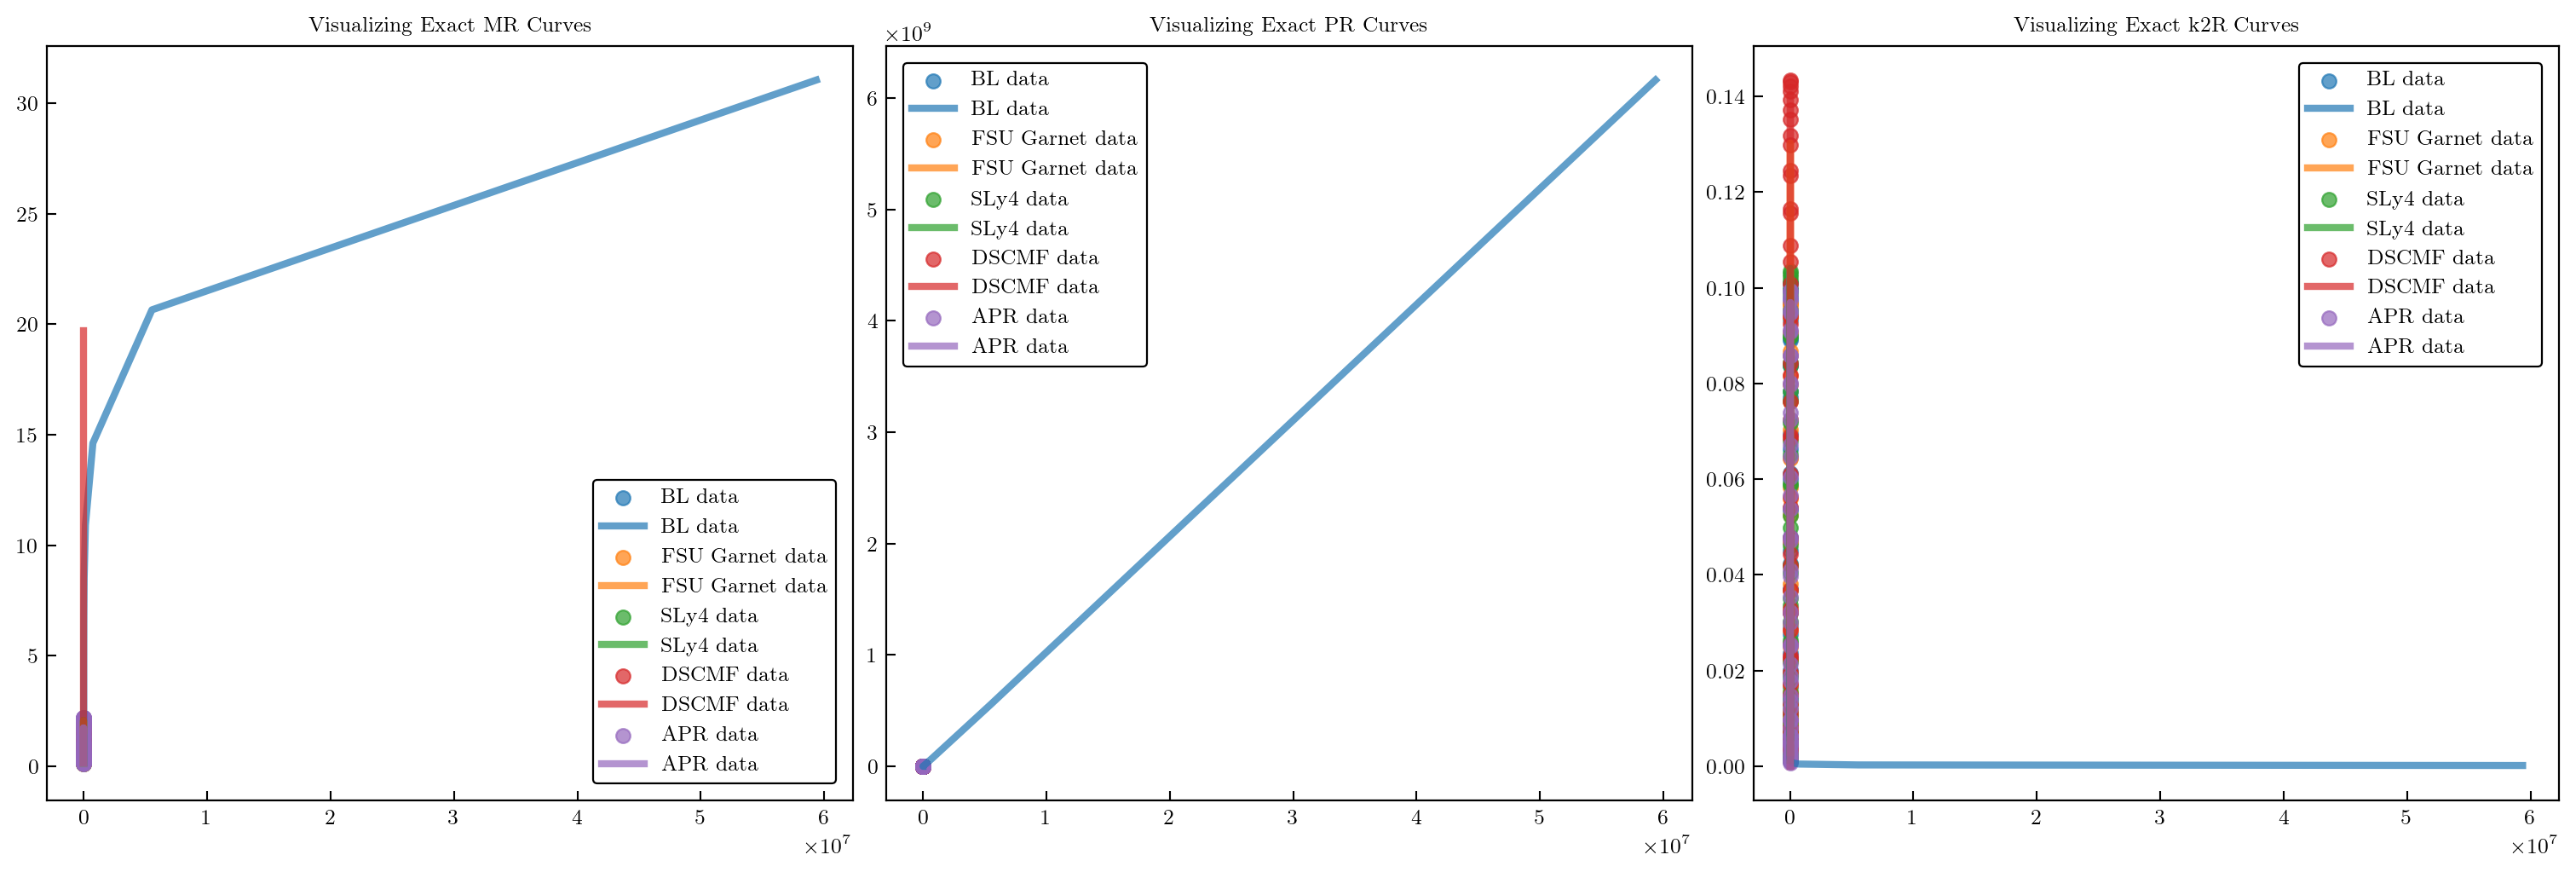

In [7]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Exact MR Curves")
for eos in eos_names:
    ax[0].scatter(exact_HF_results[eos][0], exact_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[0].legend()


ax[1].set_title("Visualizing Exact PR Curves")
for eos in eos_names:
    ax[1].scatter(exact_HF_results[eos][0], exact_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[1].legend()

ax[2].set_title("Visualizing Exact k2R Curves")
for eos in eos_names:
    ax[2].scatter(exact_HF_results[eos][0], exact_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[2].legend()

plt.show()

## Check RK4 solver

In [8]:
# store the solutions per EOS
RK4_HF_results = {}
RK4_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK4 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK4", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK4.tov_routine(verbose=False, write_to_file=False, pres_init=2.0)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK4"].append(HF_runtime)
        
        # store data
        rad = tov_RK4.total_radius
        pres = tov_RK4.total_pres_central
        mass = tov_RK4.total_mass
        tidal = tov_RK4.k2
        
        X = np.array([rad, pres, mass, tidal], dtype=np.float64)
        
        
        # Run the SLM code (that I've copy-and-pasted into this notebook).
        rad_SLM, pres_SLM, mass_SLM, tidal_SLM, SLM_runtime = SLM(X, svdSize=SLM_modes)
        X_SLM = np.array([rad_SLM, pres_SLM, mass_SLM, tidal_SLM], dtype=np.float64)
        SLM_runtimes["RK4"].append(SLM_runtime)
        
        RK4_HF_results[eos_name] = X
        RK4_SLM_results[eos_name] = X_SLM
        
        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
#




Checking BL: Woo it worked!
Max mass:  2.082758 Radius:  10.193479 Central pressure:  867.67565
(14, 50) 4
HF solved in 10.94 seconds.
SLM solved in 0.0006359 seconds.


Checking FSU Garnet: Woo it worked!
Max mass:  2.066602 Radius:  11.640836 Central pressure:  342.097307
(14, 50) 4
HF solved in 11.04 seconds.
SLM solved in 0.0005572 seconds.


Checking SLy4: Woo it worked!
Max mass:  2.067066 Radius:  10.032662 Central pressure:  867.67565
(14, 50) 4
HF solved in 10.94 seconds.
SLM solved in 0.0005531 seconds.


Checking DSCMF: Woo it worked!
Max mass:  2.022887 Radius:  11.895463 Central pressure:  292.942036
(14, 50) 4
HF solved in 10.85 seconds.
SLM solved in 0.0005569 seconds.


Checking APR: Woo it worked!
Max mass:  2.192606 Radius:  9.979056 Central pressure:  1013.27043
(14, 50) 4
HF solved in 10.92 seconds.
SLM solved in 0.0005028 seconds.


/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_48996/882326571.py:18: RuntimeWarning: overflow encountered in exp
  rad_DMD = np.exp(Xdmd[0].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_48996/882326571.py:19: RuntimeWarning: overflow encountered in exp
  pres_DMD = np.exp(Xdmd[1].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_48996/882326571.py:20: RuntimeWarning: overflow encountered in exp
  mass_DMD = np.exp(Xdmd[2].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_48996/882326571.py:21: RuntimeWarning: overflow encountered in exp
  tidal_DMD = np.exp(Xdmd[3].real)


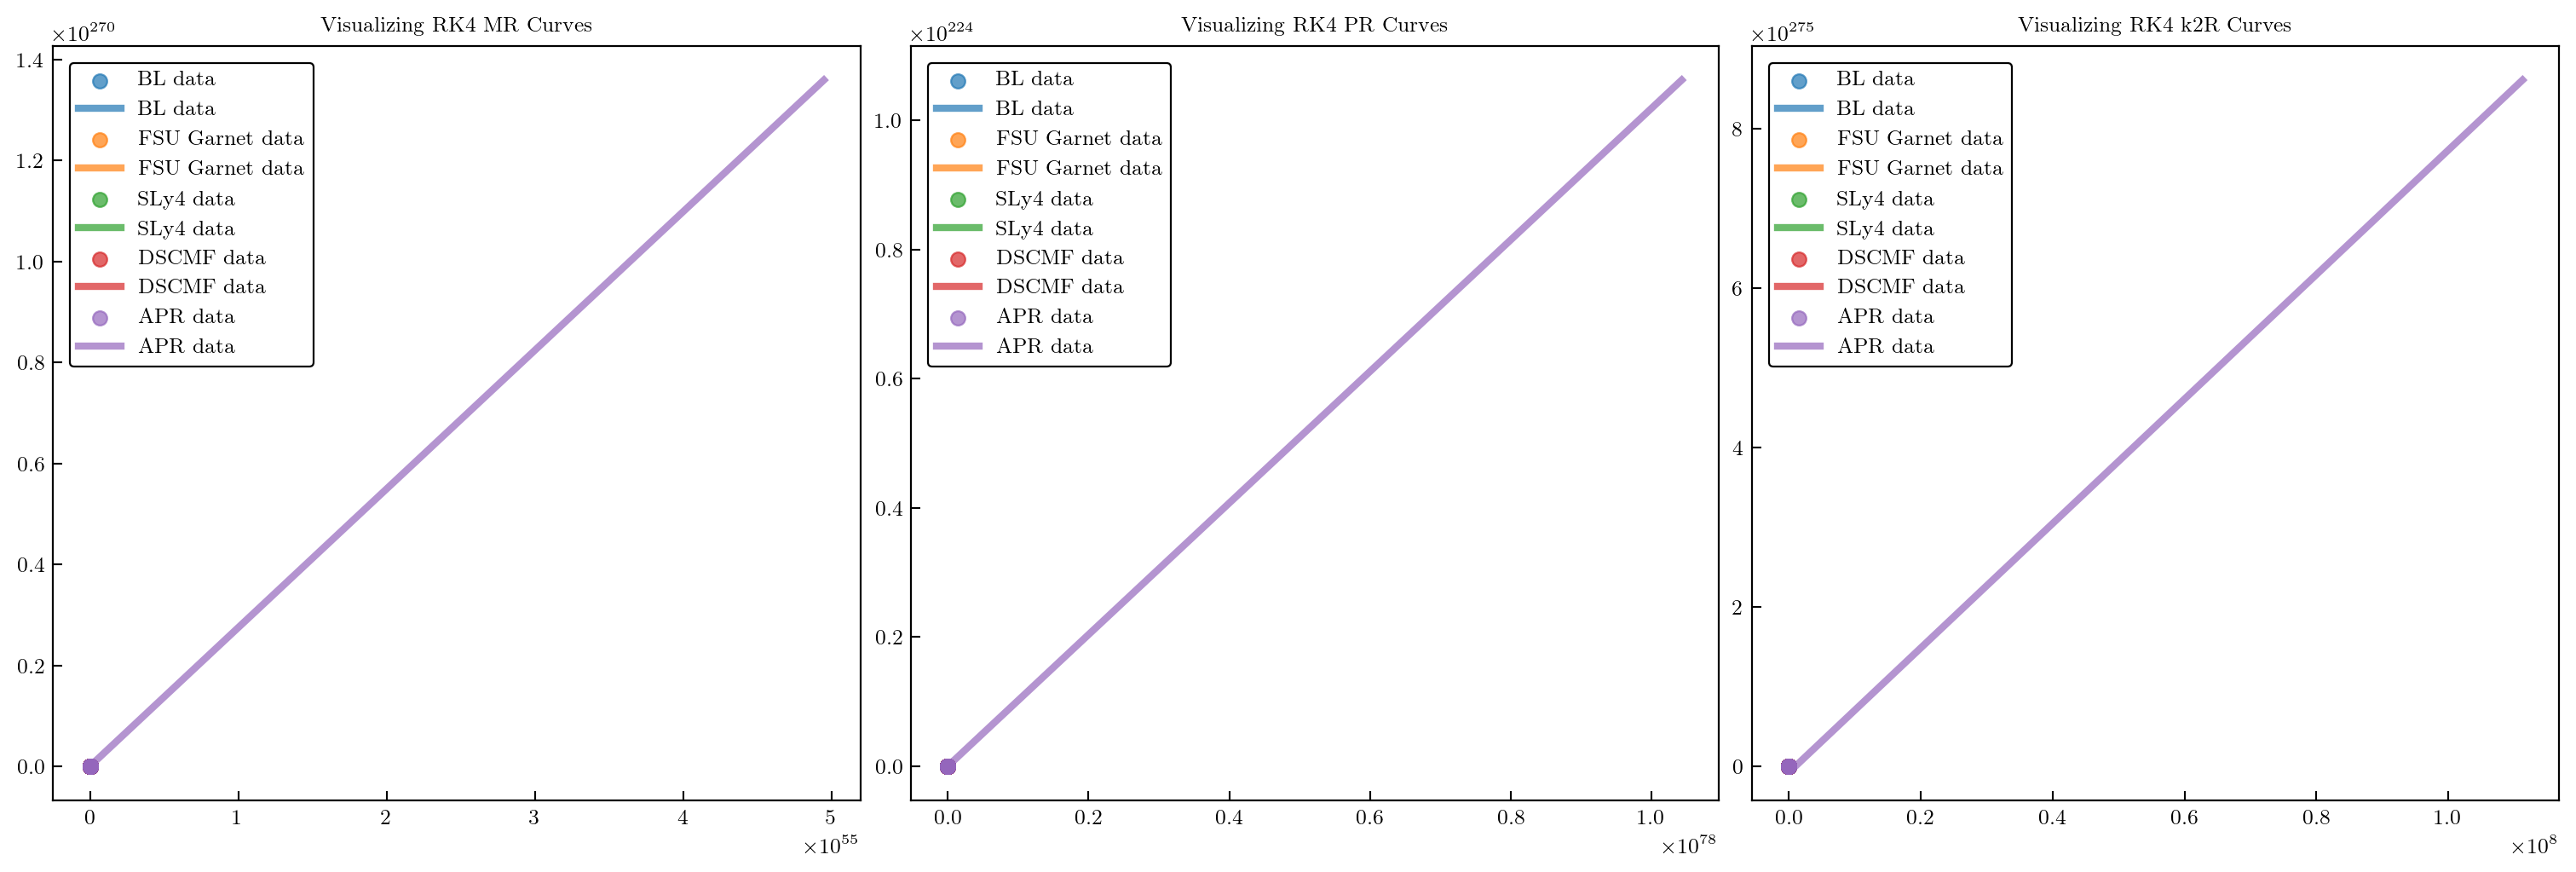

In [9]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK4 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[0].legend()


ax[1].set_title("Visualizing RK4 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[1].legend()

ax[2].set_title("Visualizing RK4 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[2].legend()

plt.show()

## Check RK2 Solver

In [10]:
# store the solutions per EOS
RK2_HF_results = {}
RK2_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK2 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK2", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK2.tov_routine(verbose=False, write_to_file=False, pres_init=2.0)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK2"].append(HF_runtime)
        
        # store data
        rad = tov_RK2.total_radius
        pres = tov_RK2.total_pres_central
        mass = tov_RK2.total_mass
        tidal = tov_RK2.k2
        
        X = np.array([rad, pres, mass, tidal], dtype=np.float64)
        
        
        # Run the SLM code (that I've copy-and-pasted into this notebook).
        rad_SLM, pres_SLM, mass_SLM, tidal_SLM, SLM_runtime = SLM(X, svdSize=SLM_modes)
        X_SLM = np.array([rad_SLM, pres_SLM, mass_SLM, tidal_SLM], dtype=np.float64)
        SLM_runtimes["RK2"].append(SLM_runtime)
        
        RK2_HF_results[eos_name] = X
        RK2_SLM_results[eos_name] = X_SLM
        
        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
#




Checking BL: Woo it worked!
Max mass:  2.082767 Radius:  10.220282 Central pressure:  867.67565
(14, 50) 4
HF solved in 5.44 seconds.
SLM solved in 0.000618 seconds.


Checking FSU Garnet: Woo it worked!
Max mass:  2.066609 Radius:  11.667638 Central pressure:  342.097307
(14, 50) 4
HF solved in 5.461 seconds.
SLM solved in 0.000484 seconds.


Checking SLy4: Woo it worked!
Max mass:  2.067075 Radius:  10.059465 Central pressure:  867.67565
(14, 50) 4
HF solved in 5.382 seconds.
SLM solved in 0.0005202 seconds.


Checking DSCMF: Woo it worked!
Max mass:  2.022894 Radius:  11.935667 Central pressure:  292.942036
(14, 50) 4
HF solved in 5.409 seconds.
SLM solved in 0.0005322 seconds.


Checking APR: Woo it worked!
Max mass:  2.192617 Radius:  10.01926 Central pressure:  1013.27043
(14, 50) 4
HF solved in 5.368 seconds.
SLM solved in 0.0005391 seconds.


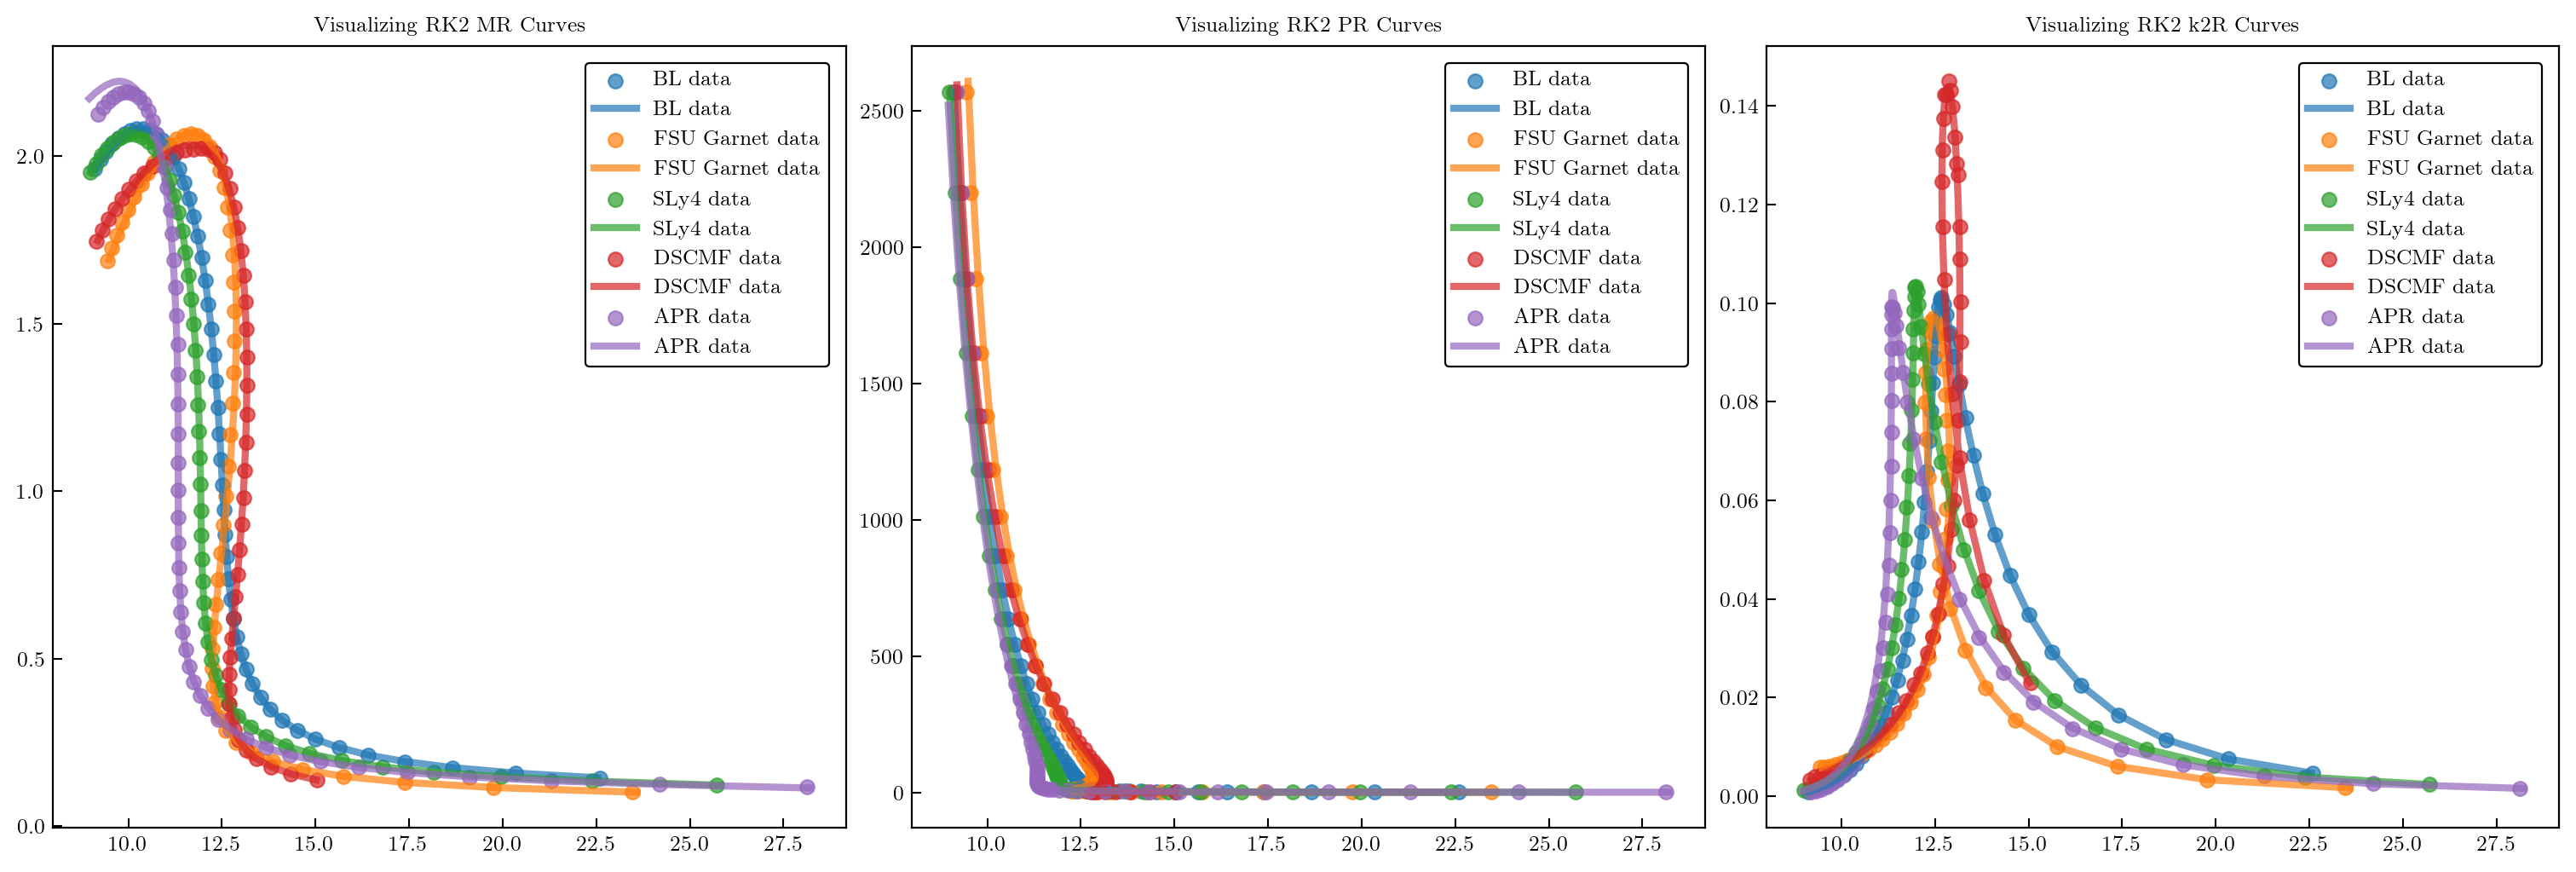

In [11]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK2 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[0].legend()


ax[1].set_title("Visualizing RK2 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[1].legend()

ax[2].set_title("Visualizing RK2 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[2].legend()

plt.show()

# Check Euler Solver

In [12]:
# store the solutions per EOS
euler_HF_results = {}
euler_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_euler = TOVsolver(f"{eos_path}{file}", tidal=True, solver="euler", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_euler.tov_routine(verbose=False, write_to_file=False, pres_init=2.0)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["euler"].append(HF_runtime)
        
        # store data
        rad = tov_euler.total_radius
        pres = tov_euler.total_pres_central
        mass = tov_euler.total_mass
        tidal = tov_euler.k2
        
        X = np.array([rad, pres, mass, tidal], dtype=np.float64)
        
        
        # Run the SLM code (that I've copy-and-pasted into this notebook).
        rad_SLM, pres_SLM, mass_SLM, tidal_SLM, SLM_runtime = SLM(X, svdSize=SLM_modes)
        X_SLM = np.array([rad_SLM, pres_SLM, mass_SLM, tidal_SLM], dtype=np.float64)
        SLM_runtimes["euler"].append(SLM_runtime)
        
        euler_HF_results[eos_name] = X
        euler_SLM_results[eos_name] = X_SLM
        
        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
#




Checking BL: Woo it worked!
Max mass:  2.081757 Radius:  10.233683 Central pressure:  743.001089
(14, 50) 4
HF solved in 2.723 seconds.
SLM solved in 0.0005469 seconds.


Checking FSU Garnet: Woo it worked!
Max mass:  2.066157 Radius:  11.533624 Central pressure:  342.097307
(14, 50) 4
HF solved in 2.726 seconds.
SLM solved in 0.0005908 seconds.


Checking SLy4: Woo it worked!
Max mass:  2.066046 Radius:  9.912049 Central pressure:  867.67565
(14, 50) 4
HF solved in 2.705 seconds.
SLM solved in 0.0005701 seconds.


Checking DSCMF: Woo it worked!
Max mass:  2.022416 Radius:  11.788251 Central pressure:  292.942036
(14, 50) 4
HF solved in 2.712 seconds.
SLM solved in 0.0007002 seconds.


Checking APR: Woo it worked!
Max mass:  2.191843 Radius:  9.83164 Central pressure:  1013.27043
(14, 50) 4
HF solved in 2.71 seconds.
SLM solved in 0.0005491 seconds.


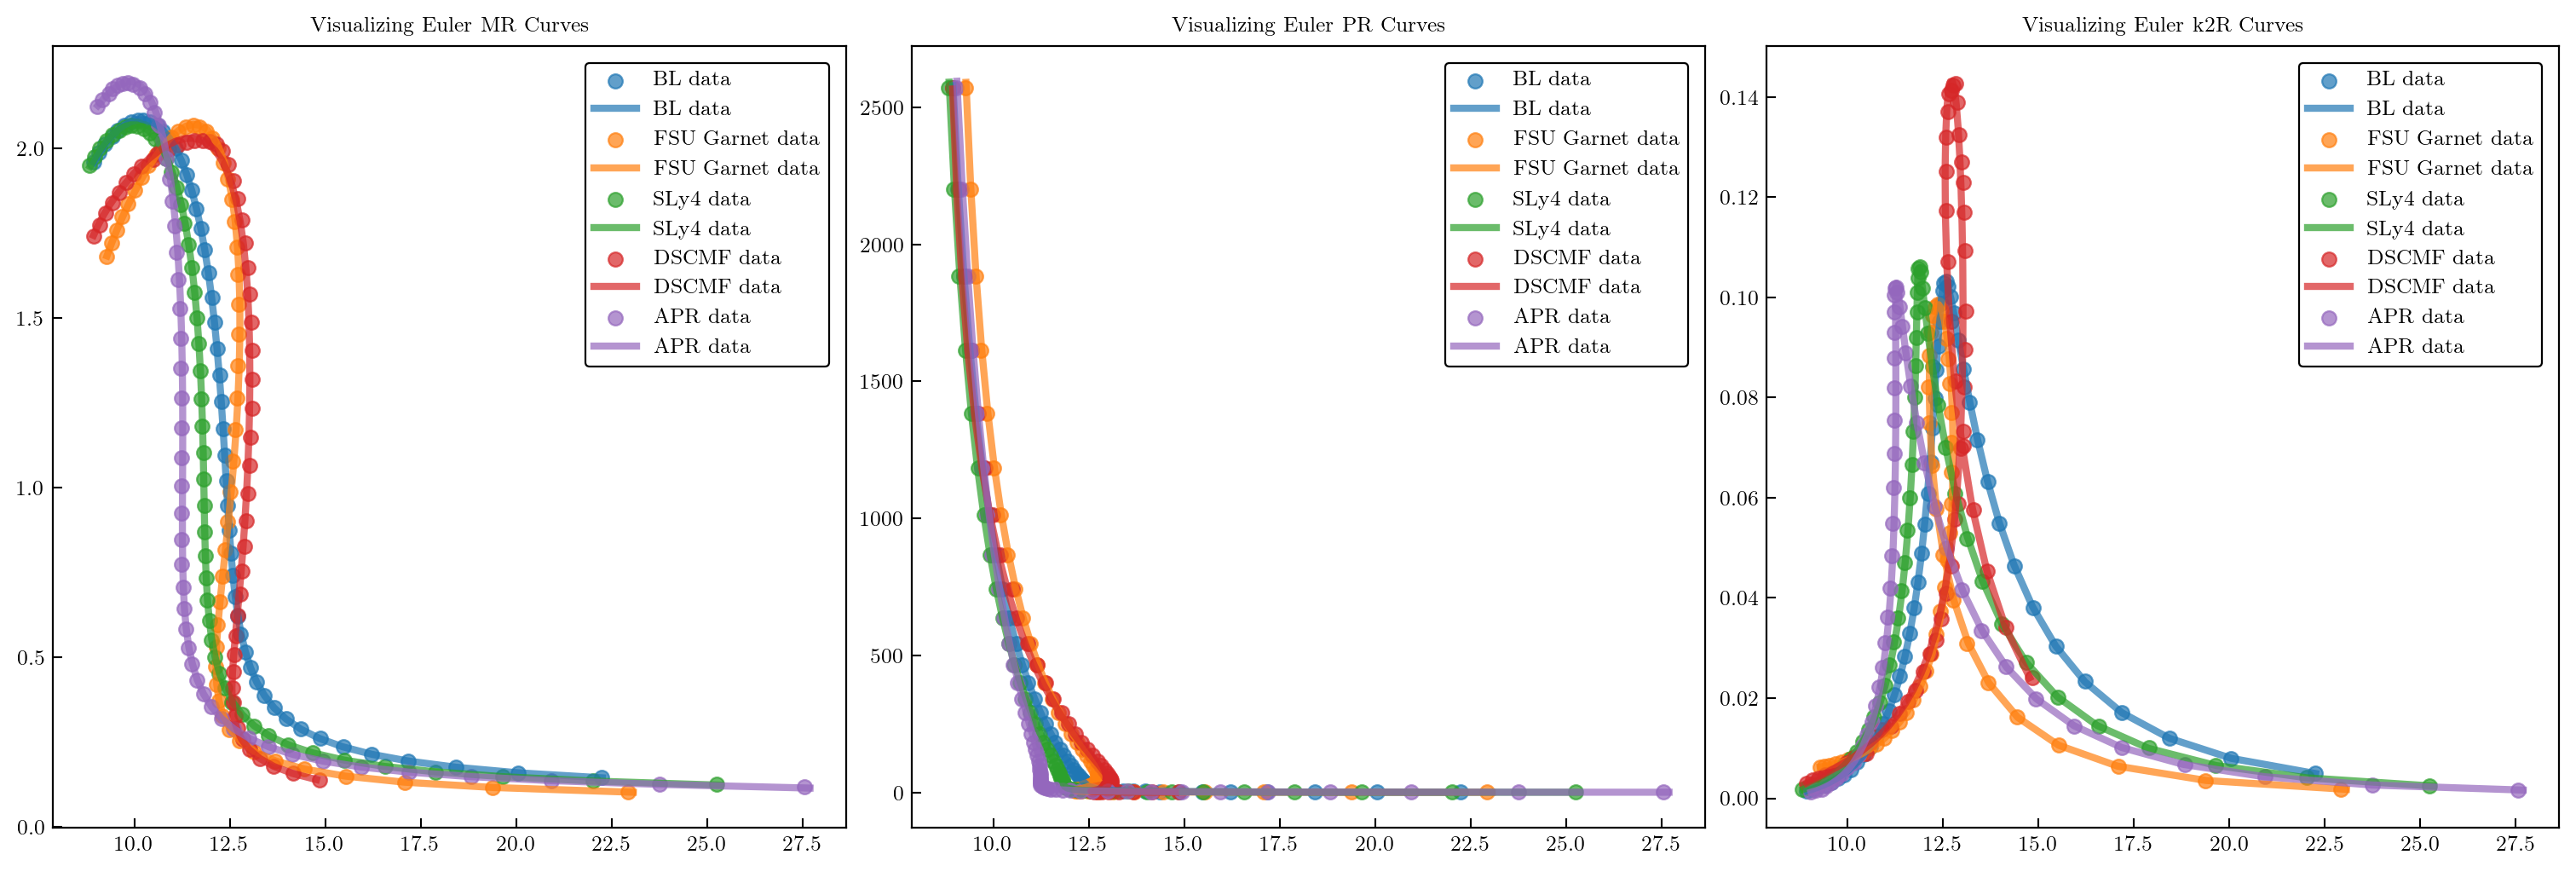

In [13]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Euler MR Curves")
for eos in eos_names:
    ax[0].scatter(euler_HF_results[eos][0], euler_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[0].legend()


ax[1].set_title("Visualizing Euler PR Curves")
for eos in eos_names:
    ax[1].scatter(euler_HF_results[eos][0], euler_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[1].legend()

ax[2].set_title("Visualizing Euler k2R Curves")
for eos in eos_names:
    ax[2].scatter(euler_HF_results[eos][0], euler_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} data")
ax[2].legend()

plt.show()

## Nice! Now look at errors

I'm not totally sure the best way to go about this. So I'll look at where the peak is on the MR curve since that's how we did the errors on the table originally.

In [14]:
def the_good_interpolator(x_tov, y_tov, x_dmd):
    # Create a normalized parameter t that corresponds to the original x values
    t_original = np.linspace(0, 1, num=len(x_tov))
    
    # Create cubic splines for original x and y
    cs_x = CubicSpline(t_original, x_tov, bc_type='natural')
    cs_y = CubicSpline(t_original, y_tov, bc_type='natural')
    
    # Create a new parameter t for the new x-values
    t_new = np.linspace(0, 1, num=len(x_dmd))
    
    # Interpolate to find the corresponding y-values for the new x-values
    y_new = cs_y(t_new)
    
    return x_dmd, y_new

def percent_error(HF, SLM):
    try:
        error = 100 * np.abs(HF - SLM) / HF
    except:
        error = np.nan
    return error

In [32]:
errors = {}  # for storing all errors
exact_HF = []  # for comparing HF solvers to the exact results

solvers = ["exact", "RK4", "RK2", "euler"]
for solver in solvers:
    for i, eos in enumerate(files_to_check):
        eos_name = eos_names[i]
        HF = eval(f"{solver}_HF_results[\"{eos_name}\"]")
        SLM = eval(f"{solver}_SLM_results[\"{eos_name}\"]")
        
        # select max point on MR curve
        # for HF
        HF_max_index = np.where(HF[2] == np.max(HF[2]))[0][0]  # grab index the maximum mass
        HF_max_rad = HF[0][HF_max_index]
        HF_max_mass = HF[2][HF_max_index]
        # for SLM
        SLM_max_index = np.where(SLM[2] == np.max(SLM[2]))[0][0]  # grab index the maximum mass
        SLM_max_rad = SLM[0][SLM_max_index]
        SLM_max_mass = SLM[2][SLM_max_index]
        
        # store the exact results for comparing to the other solvers
        if (solver == "exact"):
            exact_HF.append([HF_max_rad, HF_max_mass])
        else:
            errors[f"{eos_name} {solver} HF rad"] = percent_error(exact_HF[i][0], HF_max_rad)
            errors[f"{eos_name} {solver} HF mass"] = percent_error(exact_HF[i][1], HF_max_mass)
        
        # compare SLM to it's corresponding HF solver
        errors[f"{eos_name} {solver} SLM rad"] = percent_error(HF_max_rad, SLM_max_rad)
        errors[f"{eos_name} {solver} SLM mass"] = percent_error(HF_max_mass, SLM_max_mass)


# print results
for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    print(f"{eos_name} EOS:")
    for solver in solvers:
        if (solver != "exact"):
            print(f"{solver} HF  error:")
            print(f"   rad={errors[f"{eos_name} {solver} HF rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} HF mass"]:.6}")
            print(f"{solver} SLM error:")
            print(f"   rad={errors[f"{eos_name} {solver} SLM rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} SLM mass"]:.6}")
        else:
            print(f"{solver} SLM error:")
            print(f"   rad={errors[f"{eos_name} {solver} SLM rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} SLM mass"]:.6}")
    print("")


BL EOS:
exact SLM error:
   rad=5.82072e+08
   mass=1390.39
RK4 HF  error:
   rad=0.0444491
   mass=4.64984e-06
RK4 SLM error:
   rad=1.66831
   mass=0.0454805
RK2 HF  error:
   rad=0.218376
   mass=0.000459565
RK2 SLM error:
   rad=1.74196
   mass=0.00376255
euler HF  error:
   rad=0.349788
   mass=0.0480469
euler SLM error:
   rad=0.0556769
   mass=0.0827436

FSU Garnet EOS:
exact SLM error:
   rad=17.55
   mass=1.80352
RK4 HF  error:
   rad=0.00564985
   mass=1.89461e-06
RK4 SLM error:
   rad=0.21835
   mass=0.227844
RK2 HF  error:
   rad=0.235912
   mass=0.000344513
RK2 SLM error:
   rad=0.42334
   mass=0.244128
euler HF  error:
   rad=0.915398
   mass=0.0215033
euler SLM error:
   rad=0.0907032
   mass=0.178734

SLy4 EOS:
exact SLM error:
   rad=0.263562
   mass=0.0329309
RK4 HF  error:
   rad=0.0478419
   mass=1.12431e-05
RK4 SLM error:
   rad=0.0564352
   mass=0.073749
RK2 HF  error:
   rad=0.219187
   mass=0.000432663
RK2 SLM error:
   rad=0.146976
   mass=0.08672
euler HF  err